# DATA 608 Story 2 - Can the FED Control Inflation and Maintain Full Employment?

**Gillian McGovern**

The Federal Reserve's mandate from Congress is to control inflation and to maintain low unemployment. These seem to be contradictory objectives.

For this story you will need to source the following data for the last 25 years;


*   The Consumer Price Index (CPI) (Bureau of Labor Statistics)
*   The FED Funds Rate (FRED) (Federal Reserve Board)
*   Unemployment Rate  (Bureau of Labor Statistics)


Your Data Visualizations should be designed to answer the question "Has the FED been able to fulfill the mandate given to it by Congress?"

Notes:

You must use a different application or library to create your visualization(s) from what you used for Story -1 (e.g. If you used Excel for Story -1 you may not use it for this story)

You will receive 20 bonus point if you access the data through available APIs using code that you develop

Remember, the FED raises rate after reviewing the CPI and other data and unemployment (layoffs) occur after company operating costs go up.

This assignment is due at the end of week four of the semester

## Read in the Data

In [51]:
import requests
import json
import prettytable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

Unemployment Data:

Used the BLS API to get monthly unemployment rate seasonally adjusted (note, I was not able to get 'seasonally unadjusted' data:

In [52]:
# Unemployment Rate - seasonally adjusted
url = "https://api.bls.gov/publicAPI/v1/timeseries/data/"
headers = {'Content-type': 'application/json'}
seriesid = "LNS14000000"

# Break it up since there's a limit on time frame to pull data
json_chunk_1 = json.dumps({
    "seriesid": [seriesid],
    "startyear": "2000",
    "endyear": "2010",
})
json_chunk_2 = json.dumps({
    "seriesid": [seriesid],
    "startyear": "2010",
    "endyear": "2020",
})
json_chunk_3 = json.dumps({
    "seriesid": [seriesid],
    "startyear": "2020",
    "endyear": "2025",
})

# API request
response_1 = requests.post(url, headers=headers, data=json_chunk_1)
response_data_1 = response_1.json()
response_2 = requests.post(url, headers=headers, data=json_chunk_2)
response_data_2 = response_2.json()
response_3 = requests.post(url, headers=headers, data=json_chunk_3)
response_data_3 = response_3.json()

unemp_years = []
unemp_months = []
unemp_values = []

responses = [response_data_1, response_data_2, response_data_3]

# Process the retrieved data
for response in responses:
  if response and 'Results' in response:
    for series in response['Results']['series']:
        for item in series['data']:
            year = item['year']
            unemp_years.append(year)
            period = item['periodName']
            unemp_months.append(period)
            value = item['value']
            unemp_values.append(value)
  else:
    print("Error - no data found")

unemp_data_dict = {
    "year": unemp_years,
    "month": unemp_months,
    "unemployment_rate": unemp_values
}

unemp_data = pd.DataFrame(unemp_data_dict)

unemp_data.head()

,year,month,unemployment_rate
0,2009,December,9.9
1,2009,November,9.9
2,2009,October,10.0
3,2009,September,9.8
4,2009,August,9.6


CPI Data:

The API did not work for me trying to get the 12 month % change to get inflation rate, so I just used the Database tool via the website directly. Note, I wasn't able to get seasonally adjusted data, so I used 'seasonally unadjusted'.

FRED Data:

It looked like you needed an account for this API, so I pulled directly from the website. Since CPI data is not seasonally adjusted, I chose to use seasonally unadjusted for this data as well. In an ideal world, I would use the same seasonally adjusted feature for all datasets.

For these datasets, I will use annual average data.

In [53]:
# Read in CPI dataset because I want to use inflation percentage (12 month % change)
# Note, can only use unadjusted data for this
cpi = pd.read_csv("https://raw.githubusercontent.com/gillianmcgovern0/cuny-data-608/refs/heads/main/dataset1-SeriesReport-20250923182433_34f2b5-percent-change.csv")
fred_rate = pd.read_csv("https://raw.githubusercontent.com/gillianmcgovern0/cuny-data-608/refs/heads/main/dataset2-FEDFUNDS-monthly.csv")
# unemployment_rate = pd.read_csv("https://raw.githubusercontent.com/gillianmcgovern0/cuny-data-608/refs/heads/main/dataset3-SeriesReport-20250922215504_1356ba.csv")

## Data Cleaning

In [54]:
# Convert time info to datetime data type
fred_rate['observation_date'] = pd.to_datetime(fred_rate['observation_date'])
fred_rate['year'] = fred_rate['observation_date'].dt.year
fred_rate['month'] = fred_rate['observation_date'].dt.month
fred_rate.head()

unemp_data['year'] = pd.to_datetime(unemp_data['year'], format='%Y')
unemp_data['year'] = unemp_data['year'].dt.year

In [55]:
# Look at yearly data by taking average
fred_rate_avg = fred_rate.groupby('year')['FEDFUNDS'].mean().to_frame()
unemp_data['unemployment_rate'] = pd.to_numeric(unemp_data['unemployment_rate'])
unemp_data_avg = unemp_data.groupby('year')['unemployment_rate'].mean().to_frame()

In [56]:
# Clean up CPI data
cpi = cpi.iloc[10:]
cpi.columns = cpi.iloc[0]
cpi = cpi.iloc[1:]
cpi_data = cpi.loc[:, ['Year', 'Annual']]

In [57]:
# Convert time info to datetime data type to merge later
cpi_data['Annual'] = pd.to_numeric(cpi_data['Annual'])
cpi_data['Year'] = pd.to_datetime(cpi_data['Year'], format='%Y')
cpi_data['Year'] = cpi_data['Year'].dt.year

In [58]:
# Set the index
cpi_data.columns = ['year', 'cpi']
cpi_data_indexed = cpi_data.set_index('year')

In [59]:
# Merge CPI and unemployment data
unemp_data_avg_copy = unemp_data_avg.copy()
merged_df_1 = pd.concat([unemp_data_avg_copy, cpi_data_indexed], axis=1)
merged_df_1.head()

,unemployment_rate,cpi
year,,
2000,3.966667,2.4
2001,4.741667,2.6
2002,5.783333,2.4
2003,5.991667,1.4
2004,5.541667,1.8


In [60]:
# Merge in the FRED Rate dataset
merged_df_1_new = merged_df_1.iloc[:-1]
merged_df_1_copy = merged_df_1_new.copy()
# fred_rate_avg.index = fred_rate_avg.index.astype(object)

merged_df_2 = pd.concat([merged_df_1_copy, fred_rate_avg], axis=1)

# Final DF
merged_df_2.head()

,unemployment_rate,cpi,FEDFUNDS
year,,,
2000,3.966667,2.4,6.235833
2001,4.741667,2.6,3.887500
2002,5.783333,2.4,1.666667
2003,5.991667,1.4,1.127500
2004,5.541667,1.8,1.349167


## Problem Statement: What is the Relationship Between Inflation and Unemployment Rate?

#### A Visual Guide to Inflation

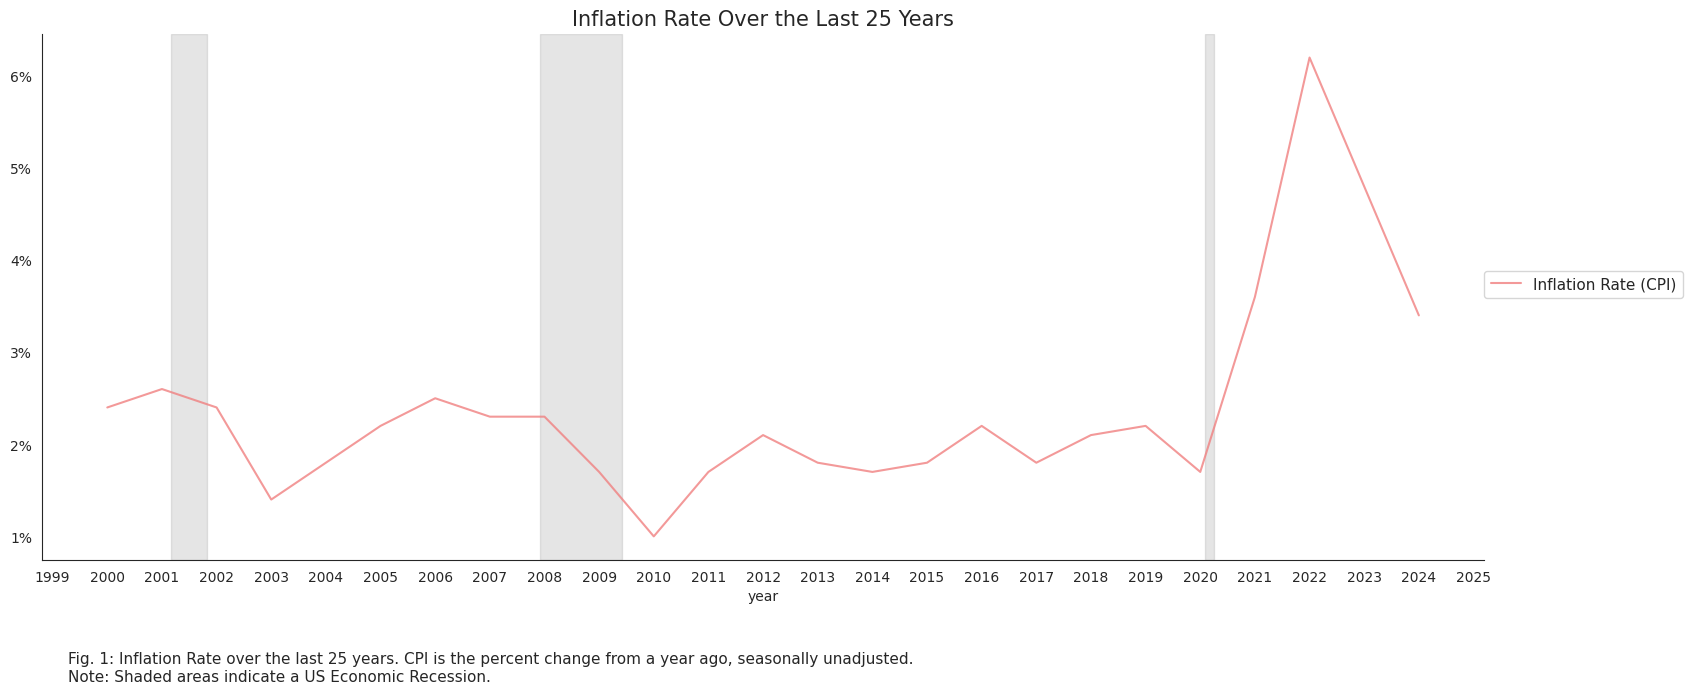

In [61]:
# Show inflation rate individually

fig, ax = plt.subplots(figsize=(15, 6))
merged_df_fig_cpi = merged_df_2.copy()
merged_df_fig_cpi = merged_df_fig_cpi[['cpi']]

color_palette = {'Inflation Rate (CPI)': 'lightcoral'}
line_styles = {'Inflation Rate (CPI)': '-'}

merged_df_fig_cpi.columns = ['Inflation Rate (CPI)']

sns.lineplot(data=merged_df_fig_cpi, palette=color_palette, dashes=False, alpha=0.8)

# Define the specific time periods to shade
year_1 = 2007.92 # Jan 2008
year_2 = 2009.42 # June 2009

year_3 = 2001.17 # March 2001
year_4 = 2001.83 # November 2001

year_5 = 2020.08 # Feb 2020
year_6 = 2020.25 # April 2020

start_date_2 = pd.to_datetime('2023-05-01')
end_date_2 = pd.to_datetime('2023-05-20')

# Add the shaded regions
ax.axvspan(year_1, year_2, color='gray', alpha=0.2)
ax.axvspan(year_3, year_4, color='gray', alpha=0.2)
ax.axvspan(year_5, year_6, color='gray', alpha=0.2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()

def percent_format(x, pos):
    return f"{x:.0f}%"
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_format))

plt.legend(bbox_to_anchor=(1, 0.55), loc='upper left', borderaxespad=0, fontsize=11)
caption_text = "Fig. 1: Inflation Rate over the last 25 years. CPI is the percent change from a year ago, seasonally unadjusted. \nNote: Shaded areas indicate a US Economic Recession."
plt.figtext(0.04, -0.1, caption_text, wrap=True, horizontalalignment='left', fontsize=11)

plt.title('Inflation Rate Over the Last 25 Years', fontsize=15)

sns.set_style("white")
sns.despine()

plt.show()

We can see here that reached a peak before the first two economic recessions. After the 2001 economic recression, inflation decreased rapidly. During the 2008 economic recession, inflation decreased as well, but not quite as rapidly as the first recession. Inflation then gradually increased with a few minor peaks and troughs until the recession in 2020 where it increased rapidly to it's highest peak. Then around 2022, it rapidly started declining.

#### A Visual Guide to Unemployment Rate

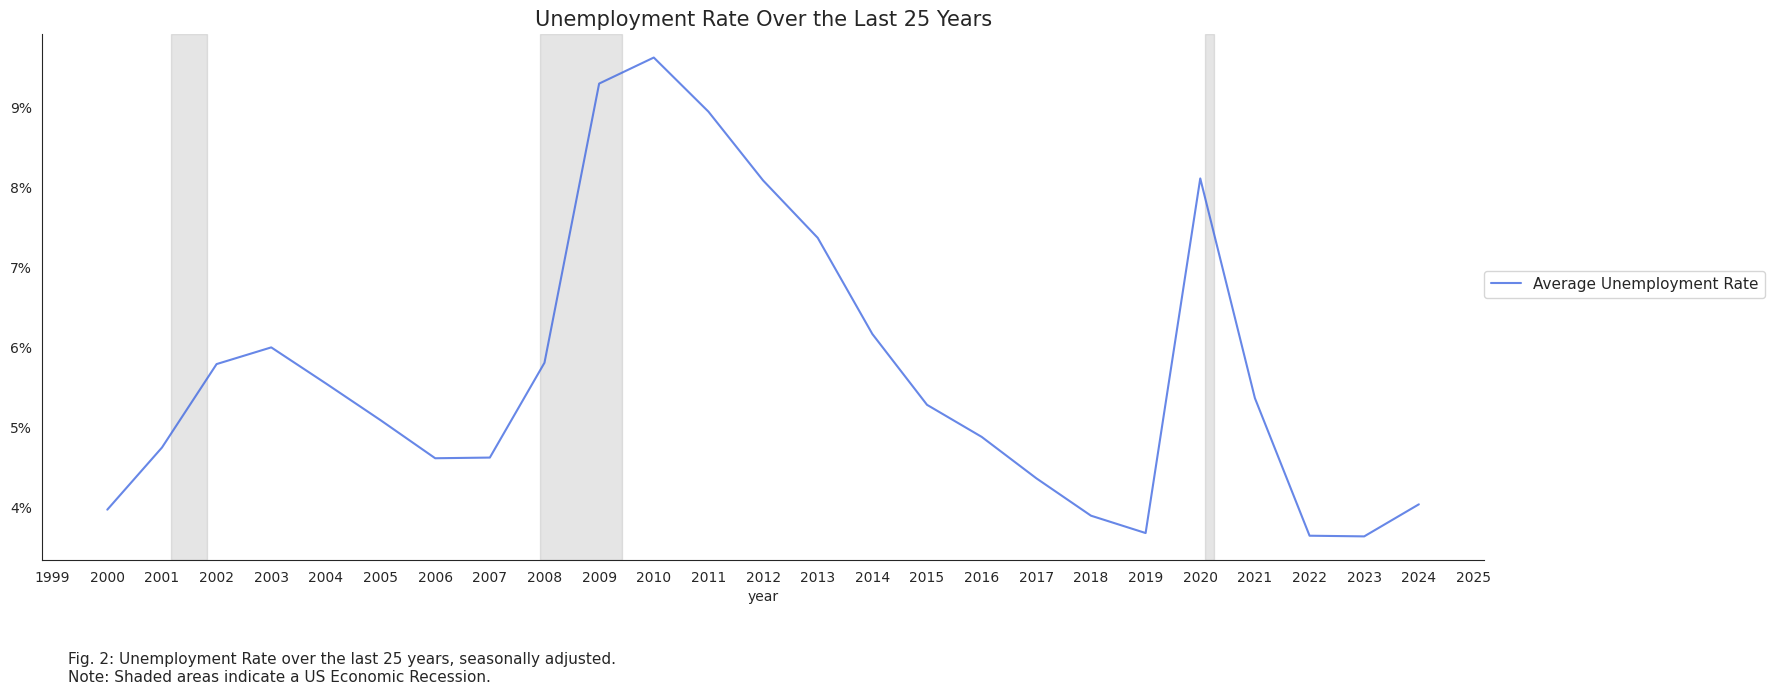

In [62]:
# Show unemployment rate individually

fig, ax = plt.subplots(figsize=(15, 6))
merged_df_fig_unemp = merged_df_2.copy()
merged_df_fig_unemp = merged_df_fig_unemp[['unemployment_rate']]

color_palette = {'Average Unemployment Rate': 'royalblue'}
line_styles = {'Average Unemployment Rate': '-'}

merged_df_fig_unemp.columns = ['Average Unemployment Rate']

sns.lineplot(data=merged_df_fig_unemp, palette=color_palette, dashes=False, alpha=0.8)

# Define the specific time periods to shade
year_1 = 2007.92 # Jan 2008
year_2 = 2009.42 # June 2009

year_3 = 2001.17 # March 2001
year_4 = 2001.83 # November 2001

year_5 = 2020.08 # Feb 2020
year_6 = 2020.25 # April 2020

start_date_2 = pd.to_datetime('2023-05-01')
end_date_2 = pd.to_datetime('2023-05-20')

# Add the shaded regions
ax.axvspan(year_1, year_2, color='gray', alpha=0.2)
ax.axvspan(year_3, year_4, color='gray', alpha=0.2)
ax.axvspan(year_5, year_6, color='gray', alpha=0.2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()

def percent_format(x, pos):
    return f"{x:.0f}%"
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_format))

plt.legend(bbox_to_anchor=(1, 0.55), loc='upper left', borderaxespad=0, fontsize=11)
caption_text = "Fig. 2: Unemployment Rate over the last 25 years, seasonally adjusted. \nNote: Shaded areas indicate a US Economic Recession."
plt.figtext(0.04, -0.1, caption_text, wrap=True, horizontalalignment='left', fontsize=11)

plt.title('Unemployment Rate Over the Last 25 Years', fontsize=15)

sns.set_style("white")
sns.despine()

plt.show()

We can see here that during the first recession low unemployment continued to rise until it reached a peak around 2003. It then started to decline until right before the 2008 economic recession. Unemployment reached it's highest peak right after the 2008 recession and slowly started to decline until 2020 in which it reached it's second highest peak. It then started rapidly declining (fastest it's been in this chart).

#### Relationship Between the Metrics

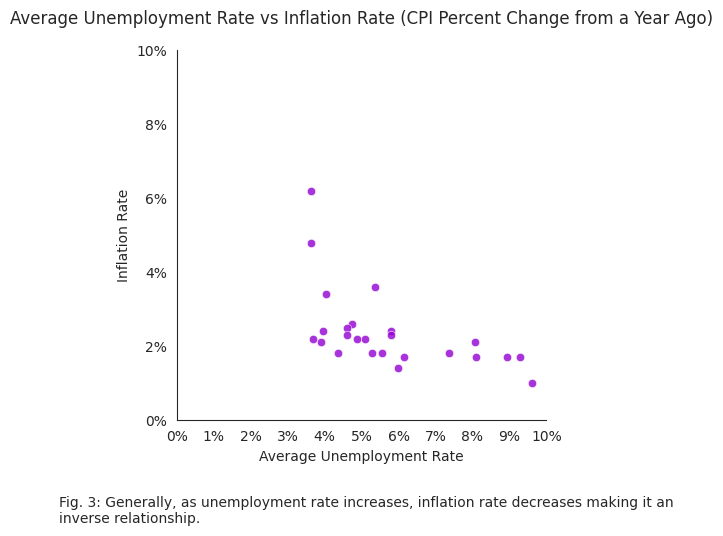

In [63]:
# Use a scatter plot to show the usual relationship between inflation (CPI) and unemployment
ax = sns.scatterplot(x=merged_df_2["unemployment_rate"], y=merged_df_2["cpi"], color="darkviolet", alpha=0.8)
ax.set_title('Average Unemployment Rate vs Inflation Rate (CPI Percent Change from a Year Ago)', fontsize=12, y=1.05)


def percentage_format(x, pos):
    return f'{x:.0f}%'  # Formats the number as an integer with a percentage sign
ax.xaxis.set_major_formatter(ticker.FuncFormatter(percentage_format))

# Axis labels
ax.set_xlabel('Average Unemployment Rate')
ax.set_ylabel('Inflation Rate')

def percent_format(x, pos):
    return f"{x:.0f}%"

# Add % sign to labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_format))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_format))

caption_text = "Fig. 3: Generally, as unemployment rate increases, inflation rate decreases making it an inverse relationship."
plt.figtext(0.04, -0.1, caption_text, wrap=True, horizontalalignment='left', fontsize=10)

# Equal x and y scale
# ax.set_aspect('equal')
plt.xlim(0, 10)
plt.ylim(0, 10)
ax.set_aspect('equal')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
sns.set_style("white")
sns.despine()

plt.show()

As we can see in the graph above, there's an inverse relationship between inflation and average unemployment rate. This is a first indication that it might be hard for the FED to control both of these rates.

This leads us to our next question, and our analysis, what's been happening with both inflation and unemployment rate over the past 25 years?

## Analysis: How has Inflation Rate and Unemployment Rate Changed Over the Last 25 Years?

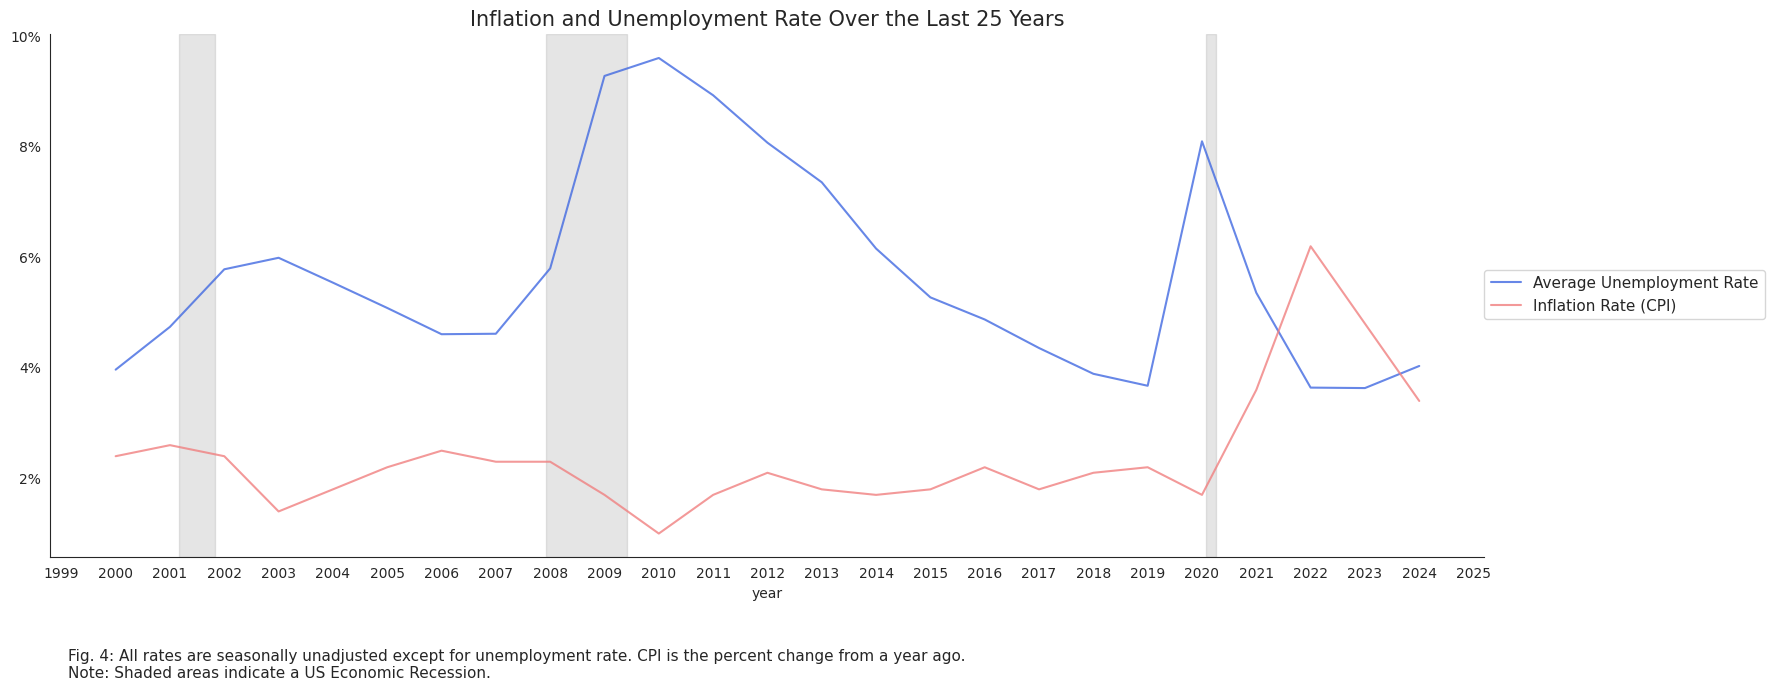

In [64]:
# Show both trends over the years

fig, ax = plt.subplots(figsize=(15, 6))
merged_df_fig_2 = merged_df_2.copy()
merged_df_fig_2 = merged_df_fig_2[['unemployment_rate', 'cpi']]

color_palette = {'Average Unemployment Rate': 'royalblue', 'Inflation Rate (CPI)': 'lightcoral'}
line_styles = {'Average Unemployment Rate': '-', 'Inflation Rate (CPI)': '-'}

merged_df_fig_2.columns = ['Average Unemployment Rate', 'Inflation Rate (CPI)']

sns.lineplot(data=merged_df_fig_2, palette=color_palette, dashes=False, alpha=0.8)

# Define the specific time periods to shade
year_1 = 2007.92 # Jan 2008
year_2 = 2009.42 # June 2009

year_3 = 2001.17 # March 2001
year_4 = 2001.83 # November 2001

year_5 = 2020.08 # Feb 2020
year_6 = 2020.25 # April 2020

start_date_2 = pd.to_datetime('2023-05-01')
end_date_2 = pd.to_datetime('2023-05-20')

# Add the shaded regions
ax.axvspan(year_1, year_2, color='gray', alpha=0.2)
ax.axvspan(year_3, year_4, color='gray', alpha=0.2)
ax.axvspan(year_5, year_6, color='gray', alpha=0.2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()

def percent_format(x, pos):
    return f"{x:.0f}%"
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_format))

plt.legend(bbox_to_anchor=(1, 0.55), loc='upper left', borderaxespad=0, fontsize=11)
caption_text = "Fig. 4: All rates are seasonally unadjusted except for unemployment rate. CPI is the percent change from a year ago. \nNote: Shaded areas indicate a US Economic Recession."
plt.figtext(0.04, -0.1, caption_text, wrap=True, horizontalalignment='left', fontsize=11)

plt.title('Inflation and Unemployment Rate Over the Last 25 Years', fontsize=15)

sns.set_style("white")
sns.despine()

plt.show()

Figure 2 shows that both rates have increased and decreased over the years with many peaks and troughs. We can see in 2008 there was a massive increase in unemployment rate, most likely due to the recession. During this time, inflation did decrease, which matches what our scatterplot showed. Overall, this graph does not show any indications of any major periods where both rates decreased and remained stable.

Yet, what has the FED done about this?

## Final Conclusion: Has the FED ever been able to control inflation and maintain low unemployment?

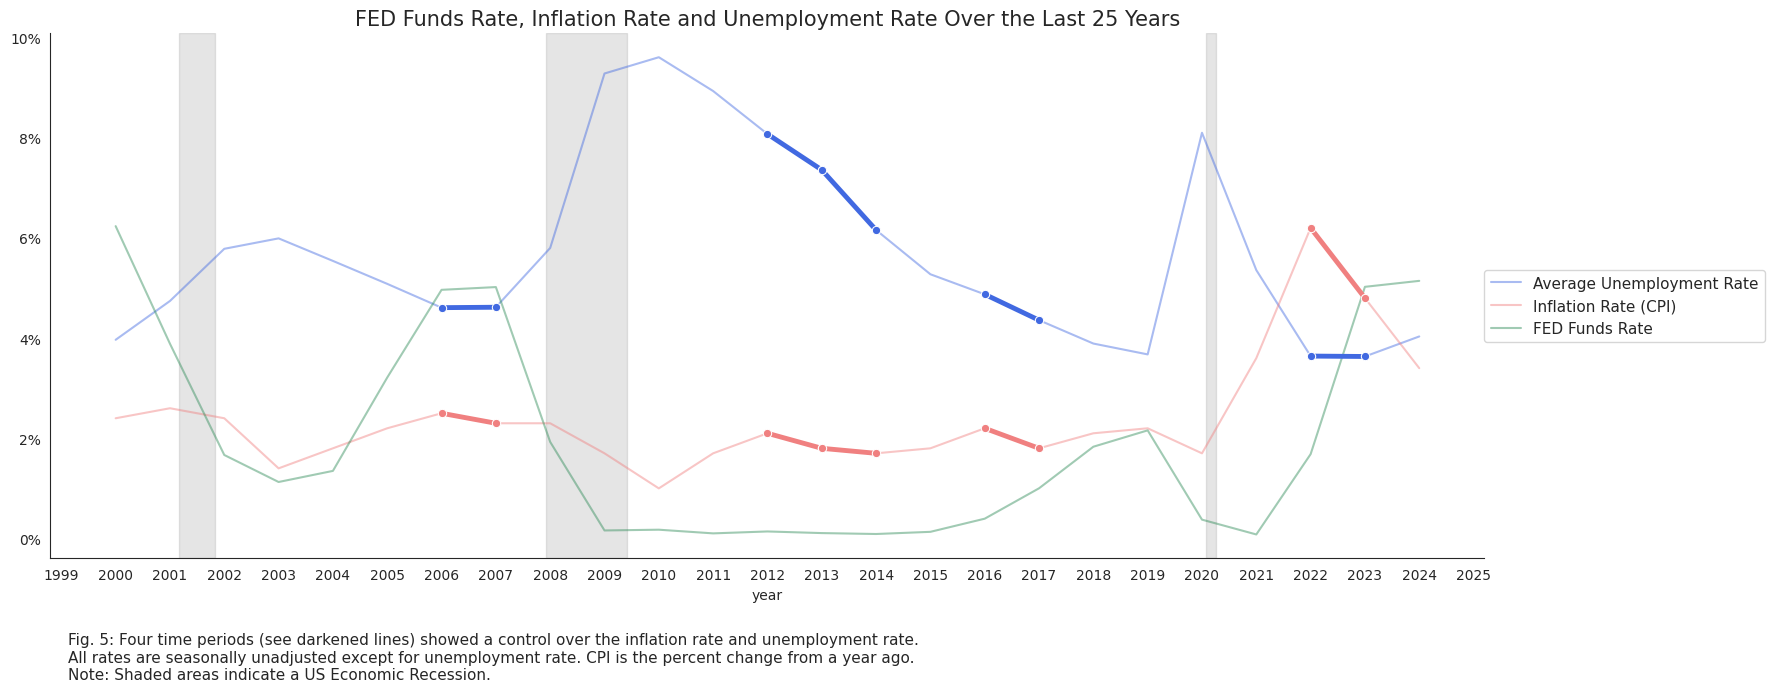

In [65]:
# Final graph with FED Funds

fig, ax = plt.subplots(figsize=(15, 6))
merged_df_fig_3 = merged_df_2.copy()
color_palette = {'Average Unemployment Rate': 'royalblue', 'Inflation Rate (CPI)': 'lightcoral', 'FED Funds Rate': 'seagreen'}
line_styles = {'Average Unemployment Rate': '-', 'Inflation Rate (CPI)': '-', 'FED Funds Rate': '-'}

merged_df_fig_3.columns = ['Average Unemployment Rate', 'Inflation Rate (CPI)', 'FED Funds Rate']

sns.lineplot(data=merged_df_fig_3, palette=color_palette, dashes=False, alpha=0.45)

# Define the specific time periods to shade
year_1 = 2007.92 # Jan 2008
year_2 = 2009.42 # June 2009

year_3 = 2001.17 # March 2001
year_4 = 2001.83 # November 2001

year_5 = 2020.08 # Feb 2020
year_6 = 2020.25 # April 2020

start_date_2 = pd.to_datetime('2023-05-01')
end_date_2 = pd.to_datetime('2023-05-20')

# Add the shaded regions
ax.axvspan(year_1, year_2, color='gray', alpha=0.2)
ax.axvspan(year_3, year_4, color='gray', alpha=0.2)
ax.axvspan(year_5, year_6, color='gray', alpha=0.2)
# Tick every 2 years
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

merged_df_fig_3_slopes = merged_df_fig_3.copy()
merged_df_fig_3_slopes['slope1'] = merged_df_fig_3_slopes['Average Unemployment Rate'].diff()
merged_df_fig_3_slopes['slope2'] = merged_df_fig_3_slopes['Inflation Rate (CPI)'].diff()
merged_df_fig_3_slopes['slope3'] = merged_df_fig_3_slopes['FED Funds Rate'].diff()

merged_df_fig_3_slopes_copy = merged_df_fig_3_slopes.copy()
filtered_df = merged_df_fig_3_slopes_copy[(merged_df_fig_3_slopes_copy['slope1'] < 0.1) & (merged_df_fig_3_slopes_copy['slope2'] < 0.1)]
# filtered_df = filtered_df[['Unemployment Rate', 'Inflation Rate (CPI)', 'FED Funds Rate']]
merged_df_fig_3_slopes_copy = merged_df_fig_3_slopes_copy[['Average Unemployment Rate', 'Inflation Rate (CPI)']]

color_palette2 = {'Average Unemployment Rate': 'royalblue', 'Inflation Rate (CPI)': 'lightcoral'}
highlight1 = merged_df_fig_3_slopes_copy[(merged_df_fig_3_slopes_copy.index >= 2006) & (merged_df_fig_3_slopes_copy.index <= 2007)]
highlight2 = merged_df_fig_3_slopes_copy[(merged_df_fig_3_slopes_copy.index >= 2012) & (merged_df_fig_3_slopes_copy.index <= 2013)]
highlight3 = merged_df_fig_3_slopes_copy[(merged_df_fig_3_slopes_copy.index >= 2013) & (merged_df_fig_3_slopes_copy.index <= 2014)]
highlight4 = merged_df_fig_3_slopes_copy[(merged_df_fig_3_slopes_copy.index >= 2016) & (merged_df_fig_3_slopes_copy.index <= 2017)]
highlight5 = merged_df_fig_3_slopes_copy[(merged_df_fig_3_slopes_copy.index >= 2022) & (merged_df_fig_3_slopes_copy.index <= 2023)]

sns.lineplot(data=highlight1, palette=color_palette, linewidth=3.5, dashes=False, marker='o', legend=False)
sns.lineplot(data=highlight2, palette=color_palette, linewidth=3.5, dashes=False, marker='o', legend=False)
sns.lineplot(data=highlight3, palette=color_palette, linewidth=3.5, dashes=False, marker='o', legend=False)
sns.lineplot(data=highlight4, palette=color_palette, linewidth=3.5, dashes=False, marker='o', legend=False)
sns.lineplot(data=highlight5, palette=color_palette, linewidth=3.5, dashes=False, marker='o', legend=False)
plt.tight_layout()

def percent_format(x, pos):
    return f"{x:.0f}%" # Formats the number as an integer with a '%' sign
ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent_format))

plt.legend(bbox_to_anchor=(1, 0.55), loc='upper left', borderaxespad=0, fontsize=11)
caption_text = "Fig. 5: Four time periods (see darkened lines) showed a control over the inflation rate and unemployment rate. \nAll rates are seasonally unadjusted except for unemployment rate. CPI is the percent change from a year ago. \nNote: Shaded areas indicate a US Economic Recession."
plt.figtext(0.04, -0.1, caption_text, wrap=True, horizontalalignment='left', fontsize=11)

plt.title('FED Funds Rate, Inflation Rate and Unemployment Rate Over the Last 25 Years', fontsize=15)

sns.set_style("white")
sns.despine()

plt.show()

We can see here that the large increase in unemployment rate was due to the recession. Additionally, we can see here in 2010, as soon as unemployment started to decrease, inflation increased. Yet, inflation remained a bit more stable compared to unemployment changes. Also during this time, we can see the FED did not do too much, as the the FED Funds rate remainded stable for a while.

Interestingly, there was a faster FED Funds response in the 2020 (Covid) recession. We see here as well that unemployment decreasd while inflation increased for the most part.

There were a few highlighted short time periods where neither inflation or unemployment increased that much. From 2006 to 2007, the FED Funds rate was at a peak, and from 2022 - 2023 the FED Funds rate was almost at a peak. The other times the FED Funds rate was not.

In conclusion, it seems hard for the FED to control both at the same time. It has accomplished it a bit over the past 25 years, but most of the time the natural inflation/unemployment inverse relationship exists.